## Here, we used new training data that has the newly determined E_0, mstar, and alpha to try and predict the phase.


In [1]:
#Load packages
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.api as sm

from sklearn import datasets
from sklearn import linear_model
from sklearn.model_selection import train_test_split

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import *

from sklearn.multioutput import MultiOutputRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler  



## This function will plot the true vs. predicted with various line fits
def plotSummary(true, predicted, name):
    #from pylab import *
    #import numpy as np
    #import matplotlib.pyplot as plt
    
    figure()
    plt.scatter(true,predicted, alpha = 0.2)
    
    plt.title(name)
    plt.xlabel('True')
    plt.ylabel('Predicted')

    xmin, xmax = plt.xlim()
    plt.plot([xmin,xmax], [xmin,xmax], c='r', linewidth = 2)  #line with slope of one

    fit_temp = np.polyfit(true, predicted,1)
    xp = np.linspace(xmin, xmax, 100)
    p = np.poly1d(fit_temp)
    plt.plot(xp, p(xp), '-', color = 'black')
    
    print(' ')
    print('RMSE on test data:', np.sqrt(mean_squared_error(true, predicted)), 'for ', name)
    print('R^2 Score on test data:', r2_score(true, predicted), 'for', name)

    
    return

def myResiduals(testY, predictY):
    ## residuals 1
    i = 0 # resetting i
    iterations = len(testY) # gets number of dots/points
    residual_sum = 0 # initializes sum of residuals
    for i in range (0,iterations): # for every dot/point
       ys = testY # get ys of testing data
       ys = ys.values # take out indexing, data types, names
       y = ys[i]
       predict_ys = predictY.values # get ys of all dots/points
       predict_y = predict_ys[i] # get the y value of the dot/point at specfic x value i
       diff = y - predict_y # find the difference in height
       diff = abs(diff) # take the absolute value
       residual_sum = diff + residual_sum # add specific residual sum at i to sum of residuals
    residual_average = residual_sum/iterations # find the average of the residuals
    print('The average residual for predict:', round(residual_average,4)) # display average of residuals

    minY = min(ys) # find the minimum y value for testing data
    maxY = max(ys) # find the max y value for testing data
    minpredict = min(predictY) # find the min y value for the prediction data
    maxpredict = max(predictY) # find the max y value for the prediction data
    #print('minY', minY, 'maxY', maxY)
    #print('minpredict', minpredict, 'maxpredict', maxpredict)
    rangeY = minY + maxY # find the range of the testing data
    rangepredict = minpredict - maxpredict # find the range of the predictions
    #print('rangeY', rangeY)
    #print('rangepredict', rangepredict)
    residual_percent_rangepredict = (residual_average/abs(rangepredict))*100 # calculate what percent the residual is of the range
    print('Residual is this percent of predict range', round(residual_percent_rangepredict,3), '%')
    
    return
    

## Made new training data with E_0 and mstar fixed. 

In [2]:
#Load the training data

subset = 5 #every 10 mV
start = 50 # for starting at -300mV

peak_names = ['peak1', 'peak2', 'peak3', 'peak4']
locs_names = ['loc1', 'loc2', 'loc3', 'loc4']
width_names = ['width1', 'width2', 'width3','width4']
prom_names = ['prom1', 'prom2', 'prom3', 'prom4']

energy = (pd.read_csv('Training_Data/Hexagon/HexagonBias_v4.csv', header=None)*1000).round().astype(int)
energy_names = ['E_%i_mV' % item for item in list(energy.T[0])]
energy_names2 = energy_names[start::subset]
energy_names3 = energy_names[start::1]

col_names2 = ['deltaI', 'deltaR', 'E_0', 'mstar', 'alpha']+ peak_names + locs_names + width_names + prom_names
col_names2a = ['deltaI', 'deltaR', 'E_0', 'mstar', 'alpha']+ peak_names[1:] + locs_names + width_names + prom_names[1:]

col_names1 = ['deltaI', 'deltaR', 'E_0', 'mstar', 'alpha'] + energy_names

#col_names_both = col_names2 + energy_names2
col_names_both = col_names2a + energy_names2
col_names_a = ['deltaI', 'deltaR', 'E_0', 'mstar', 'alpha'] + energy_names3

data1 = pd.read_csv('Training_Data/Hexagon/HexagonTrainingData071318_v12_E0Mafixed_specPoints.csv', header = None, names = col_names1)
data2 = pd.read_csv('Training_Data/Hexagon/HexagonTrainingData071318_v12_E0Mafixed_peakinfo.csv', header = None, names = col_names2)
save_data = True


data = data2.join(data1.drop(['deltaI', 'deltaR', 'E_0', 'mstar', 'alpha'], axis = 1), how = 'left')
data = data[col_names_both]

data1a = data1[col_names_a]
data2a = data2[col_names2a]


X1 = data1a.drop(['deltaI', 'deltaR', 'E_0', 'mstar', 'alpha'], axis = 1)
Y1 = data1a[['deltaI', 'deltaR']]

X2 = data2a.drop(['deltaI', 'deltaR', 'E_0', 'mstar', 'alpha'], axis = 1)
Y2 = data2a[['deltaI', 'deltaR']]

X = data.drop(['deltaI', 'deltaR', 'E_0', 'mstar', 'alpha'], axis = 1)
Y = data[['deltaI', 'deltaR']]

ts1 = 0.3
rs1 = 42

X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, Y1, test_size = ts1, random_state = rs1)
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y2, test_size = ts1, random_state = rs1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = ts1, random_state = rs1)

data1.head()

,deltaI,deltaR,E_0,mstar,alpha,E_-400_mV,E_-398_mV,E_-396_mV,E_-394_mV,E_-392_mV,...,E_482_mV,E_484_mV,E_486_mV,E_488_mV,E_490_mV,E_492_mV,E_494_mV,E_496_mV,E_498_mV,E_500_mV
0,0.81472,-0.147980,0.44839,0.338,-12.353,0.137260,0.136640,0.137770,0.140470,0.144820,...,1.35590,1.39830,1.43940,1.4779,1.5133,1.5455,1.5723,1.5926,1.6077,1.6167
1,0.09754,-1.133300,0.44839,0.338,-12.353,0.027749,0.027618,0.027902,0.028146,0.028961,...,0.70672,0.83022,0.99004,1.1992,1.4872,1.8853,2.4502,3.2372,4.3318,5.7200
2,0.15761,-0.046193,0.44839,0.338,-12.353,0.347930,0.352950,0.361910,0.374820,0.391880,...,1.13370,1.13450,1.13480,1.1346,1.1338,1.1328,1.1312,1.1291,1.1267,1.1241
3,0.14189,-0.908300,0.44839,0.338,-12.353,0.029754,0.029835,0.030257,0.031104,0.032282,...,1.99500,2.51640,3.21390,4.1022,5.1170,6.0202,6.3792,5.9836,5.0919,4.0893
4,0.65574,-1.514700,0.44839,0.338,-12.353,0.075590,0.075005,0.075484,0.076755,0.078976,...,1.08470,1.16250,1.24870,1.3427,1.4462,1.5586,1.6777,1.7992,1.9237,2.0462


## Statsmodels OLS

### spec points

 
RMSE on test data: 21.81479446783257 for  Delta I
R^2 Score on test data: -5666.825131458515 for Delta I
 
RMSE on test data: 12.637973632391871 for  Delta R
R^2 Score on test data: -789.6908903719188 for Delta R


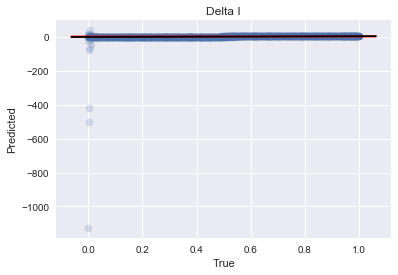

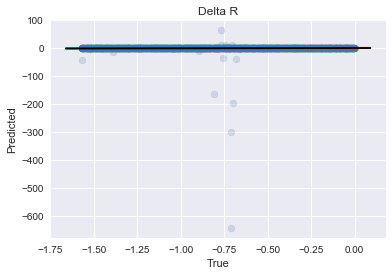

In [3]:
#Initialize and fit OLS model for deltaI 
E0Ma_model_OLS_I_sp = sm.OLS(Y1_train['deltaI'], X1_train)
E0Ma_model_OLS_R_sp = sm.OLS(Y1_train['deltaR'], X1_train)

E0Ma_results_OLS_I_sp = E0Ma_model_OLS_I_sp.fit()
E0Ma_results_OLS_R_sp = E0Ma_model_OLS_R_sp.fit()

#Make predictions on testing data
E0Ma_predictions_OLS_I_sp = E0Ma_results_OLS_I_sp.predict(X1_test) # make the predictions by the model
E0Ma_predictions_OLS_R_sp = E0Ma_results_OLS_R_sp.predict(X1_test)

E0Ma_scores_OLS = [r2_score(Y1_test['deltaI'], E0Ma_predictions_OLS_I_sp), 
                 r2_score(Y1_test['deltaR'], E0Ma_predictions_OLS_R_sp)]

#If we plot the predictions against the test data, a perfect model should be linear

plotSummary(Y1_test['deltaI'], E0Ma_predictions_OLS_I_sp,'Delta I')
#ylim([-1,5])
plotSummary(Y1_test['deltaR'], E0Ma_predictions_OLS_R_sp, 'Delta R')


### peak info

 
RMSE on test data: 0.13330693523358444 for  Delta I
R^2 Score on test data: 0.788349314505873 for Delta I
 
RMSE on test data: 0.3065269128672981 for  Delta R
R^2 Score on test data: 0.5348542383881476 for Delta R


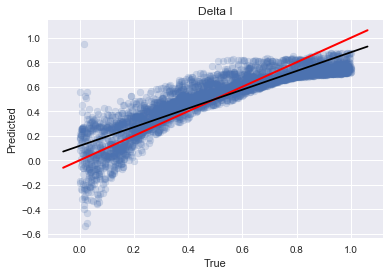

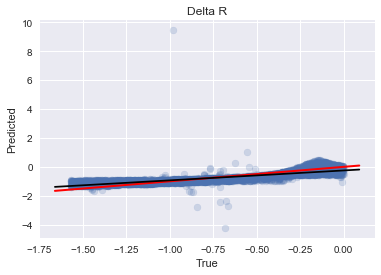

In [4]:
#Initialize and fit OLS model for deltaI 
E0Ma_model_OLS_I_pi = sm.OLS(Y2_train['deltaI'], X2_train)
E0Ma_model_OLS_R_pi = sm.OLS(Y2_train['deltaR'], X2_train)

E0Ma_results_OLS_I_pi = E0Ma_model_OLS_I_pi.fit()
E0Ma_results_OLS_R_pi = E0Ma_model_OLS_R_pi.fit()

#Make predictions on testing data
E0Ma_predictions_OLS_I_pi = E0Ma_results_OLS_I_pi.predict(X2_test) # make the predictions by the model
E0Ma_predictions_OLS_R_pi = E0Ma_results_OLS_R_pi.predict(X2_test)

E0Ma_scores_OLS_pi = [r2_score(Y2_test['deltaI'], E0Ma_predictions_OLS_I_pi), 
                 r2_score(Y2_test['deltaR'], E0Ma_predictions_OLS_R_pi)]

#If we plot the predictions against the test data, a perfect model should be linear

plotSummary(Y2_test['deltaI'], E0Ma_predictions_OLS_I_pi,'Delta I')
#ylim([-1,5])
plotSummary(Y2_test['deltaR'], E0Ma_predictions_OLS_R_pi, 'Delta R')

### spec points and peak info

 
RMSE on test data: 0.11692645767971775 for  Delta I
R^2 Score on test data: 0.8371679925430029 for Delta I
 
RMSE on test data: 0.5027921290246191 for  Delta R
R^2 Score on test data: -0.25149404144220866 for Delta R


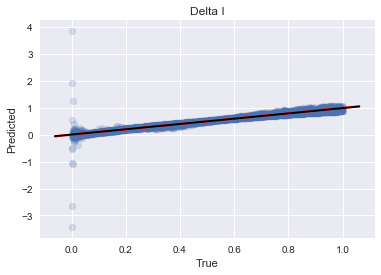

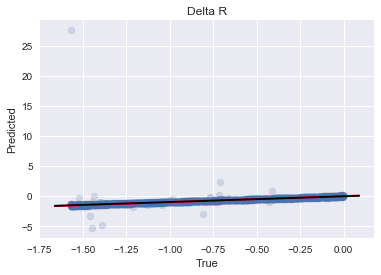

In [5]:
#Initialize and fit OLS model for deltaI 
E0Ma_model_OLS_I_both = sm.OLS(Y_train['deltaI'], X_train)
E0Ma_model_OLS_R_both = sm.OLS(Y_train['deltaR'], X_train)

E0Ma_results_OLS_I_both = E0Ma_model_OLS_I_both.fit()
E0Ma_results_OLS_R_both = E0Ma_model_OLS_R_both.fit()

#Make predictions on testing data
E0Ma_predictions_OLS_I_both = E0Ma_results_OLS_I_both.predict(X_test) # make the predictions by the model
E0Ma_predictions_OLS_R_both = E0Ma_results_OLS_R_both.predict(X_test)

E0Ma_scores_OLS_both = [r2_score(Y_test['deltaI'], E0Ma_predictions_OLS_I_both), 
                 r2_score(Y_test['deltaR'], E0Ma_predictions_OLS_R_both)]

#If we plot the predictions against the test data, a perfect model should be linear

plotSummary(Y_test['deltaI'], E0Ma_predictions_OLS_I_both,'Delta I')
#ylim([-1,5])
plotSummary(Y_test['deltaR'], E0Ma_predictions_OLS_R_both, 'Delta R')

## Decision Tree

### spec points

 
RMSE on test data: 0.009784170621733231 for  deltaI Depth 60
R^2 Score on test data: 0.9988598493831053 for deltaI Depth 60
 
RMSE on test data: 0.010639334058692971 for  deltaR Depth 60
R^2 Score on test data: 0.9994396224398691 for deltaR Depth 60


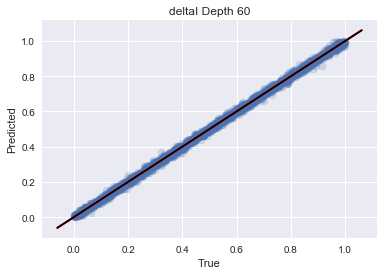

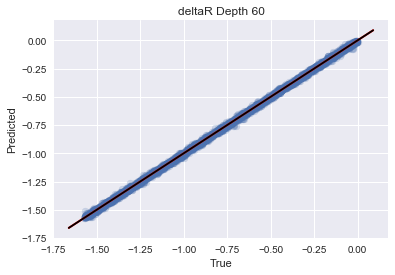

In [6]:
#Initialize the model
rs = 42
E0Ma_regr_DT_sp = DecisionTreeRegressor(max_depth=60, min_samples_leaf = 2, random_state = rs)

#Fit the model
E0Ma_regr_DT_sp = E0Ma_regr_DT_sp.fit(X1_train, Y1_train)


#Use model to predict
E0Ma_predictions_DT_sp = E0Ma_regr_DT_sp.predict(X1_test)

E0Ma_scores_DT = [r2_score(Y1_test['deltaI'], E0Ma_predictions_DT_sp[:,0]), 
                r2_score(Y1_test['deltaR'], E0Ma_predictions_DT_sp[:,1]) ]

#Plot results
plotSummary(Y1_test['deltaI'], E0Ma_predictions_DT_sp[:,0], 'deltaI Depth 60')
#myResiduals(Y_test['deltaI'], y_3[:,0])
plotSummary(Y1_test['deltaR'], E0Ma_predictions_DT_sp[:,1], 'deltaR Depth 60')
#myResiduals(Y_test['deltaR'], y_3[:,1])

### peak info

 
RMSE on test data: 0.013287720083193044 for  deltaI Depth 60
R^2 Score on test data: 0.9978971168893068 for deltaI Depth 60
 
RMSE on test data: 0.016971649060250255 for  deltaR Depth 60
R^2 Score on test data: 0.9985740643364875 for deltaR Depth 60


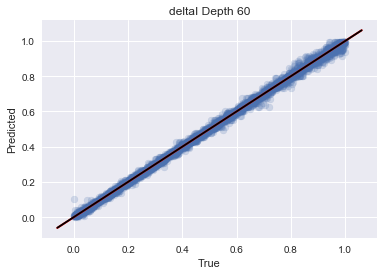

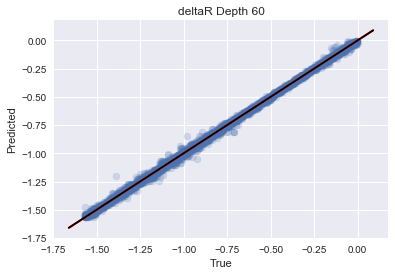

In [7]:
#Initialize the model
rs = 42
E0Ma_regr_DT_pi = DecisionTreeRegressor(max_depth=60, min_samples_leaf = 2, random_state = rs)

#Fit the model
E0Ma_regr_DT_pi.fit(X2_train, Y2_train)


#print(data1[data1['Regr - DT']>0.001])

#Use model to predict
E0Ma_predictions_DT_pi = E0Ma_regr_DT_pi.predict(X2_test)

E0Ma_scores_DT_pi = [r2_score(Y2_test['deltaI'], E0Ma_predictions_DT_pi[:,0]), 
                r2_score(Y2_test['deltaR'], E0Ma_predictions_DT_pi[:,1])]

#Plot results
plotSummary(Y2_test['deltaI'], E0Ma_predictions_DT_pi[:,0], 'deltaI Depth 60')
#myResiduals(Y_test['deltaI'], y_3[:,0])
plotSummary(Y2_test['deltaR'], E0Ma_predictions_DT_pi[:,1], 'deltaR Depth 60')
#myResiduals(Y_test['deltaR'], y_3[:,1])

### spec points and peak info

 
RMSE on test data: 0.010196431335141263 for  deltaI Depth 60
R^2 Score on test data: 0.9987617435771293 for deltaI Depth 60
 
RMSE on test data: 0.010610990211000973 for  deltaR Depth 60
R^2 Score on test data: 0.9994426042240927 for deltaR Depth 60


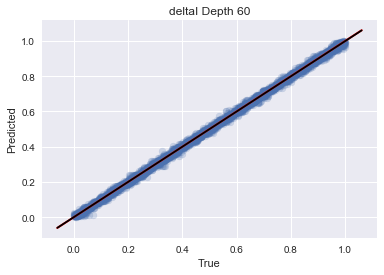

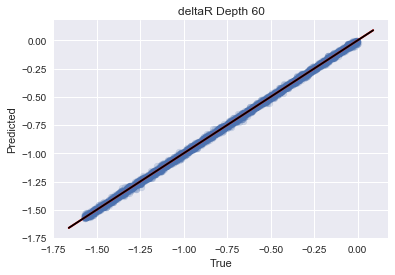

In [8]:
#Initialize the model
rs = 42
E0Ma_regr_DT_both = DecisionTreeRegressor(max_depth=60, min_samples_leaf = 2, random_state = rs)

#Fit the model
E0Ma_regr_DT_both.fit(X_train, Y_train)

#print(data1[data1['Regr - DT']>0.001])

#Use model to predict
E0Ma_predictions_DT_both = E0Ma_regr_DT_both.predict(X_test)

E0Ma_scores_DT_both = [r2_score(Y_test['deltaI'], E0Ma_predictions_DT_both[:,0]), 
                r2_score(Y_test['deltaR'], E0Ma_predictions_DT_both[:,1])]

#Plot results
plotSummary(Y_test['deltaI'], E0Ma_predictions_DT_both[:,0], 'deltaI Depth 60')
#myResiduals(Y_test['deltaI'], y_3[:,0])
plotSummary(Y_test['deltaR'], E0Ma_predictions_DT_both[:,1], 'deltaR Depth 60')
#myResiduals(Y_test['deltaR'], y_3[:,1])

## Random Forests

### spec points


Score - Random Forest: 0.9999078528069603 for delta I/R 10
 
RMSE on test data: 0.003808909087932486 for  deltaI 10
R^2 Score on test data: 0.9998272112728921 for deltaI 10
 
RMSE on test data: 0.0034413258243200674 for  deltaR 10
R^2 Score on test data: 0.9999413722223001 for deltaR 10


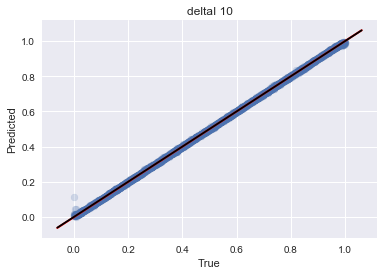

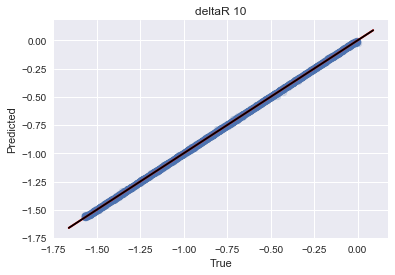

In [9]:
rs = 42
E0Ma_regr_RF_sp = RandomForestRegressor(max_depth = 40, n_estimators = 30, random_state=rs)

E0Ma_model_RF_sp = E0Ma_regr_RF_sp.fit(X1_train, Y1_train)

E0Ma_predictions_RF_sp = E0Ma_model_RF_sp.predict(X1_test)

E0Ma_scores_RF = [r2_score(Y1_test['deltaI'], E0Ma_predictions_RF_sp[:,0]), 
                r2_score(Y1_test['deltaR'], E0Ma_predictions_RF_sp[:,1])]

print('')
print('Score - Random Forest:' , E0Ma_model_RF_sp.score(X1_test, Y1_test), 'for delta I/R 10')

plotSummary(Y1_test['deltaI'], E0Ma_predictions_RF_sp[:,0], 'deltaI 10')
plotSummary(Y1_test['deltaR'], E0Ma_predictions_RF_sp[:,1], 'deltaR 10')


### peak info

 
RMSE on test data: 0.010045192788277582 for  deltaI 10
R^2 Score on test data: 0.9987982040287119 for deltaI 10
 
RMSE on test data: 0.012788347657592755 for  deltaR 10
R^2 Score on test data: 0.9991903809582333 for deltaR 10


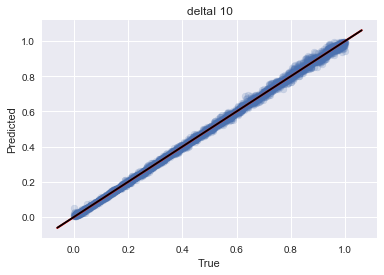

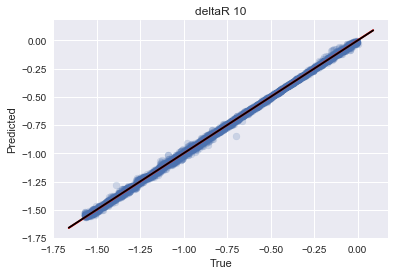

In [10]:
rs = 42
E0Ma_regr_RF_pi = RandomForestRegressor(max_depth = 40, n_estimators = 30, random_state=rs)

E0Ma_model_RF_pi = E0Ma_regr_RF_pi.fit(X2_train, Y2_train)

E0Ma_predictions_RF_pi = E0Ma_model_RF_pi.predict(X2_test)

E0Ma_scores_RF_pi = [r2_score(Y2_test['deltaI'], E0Ma_predictions_RF_pi[:,0]), 
                   r2_score(Y2_test['deltaR'], E0Ma_predictions_RF_pi[:,1])]

plotSummary(Y2_test['deltaI'], E0Ma_predictions_RF_pi[:,0], 'deltaI 10')
plotSummary(Y2_test['deltaR'], E0Ma_predictions_RF_pi[:,1], 'deltaR 10')

### spec points and peak info

 
RMSE on test data: 0.004012501393321149 for  deltaI 10
R^2 Score on test data: 0.9998082459329913 for deltaI 10
 
RMSE on test data: 0.0041082110657866214 for  deltaR 10
R^2 Score on test data: 0.9999164479054619 for deltaR 10


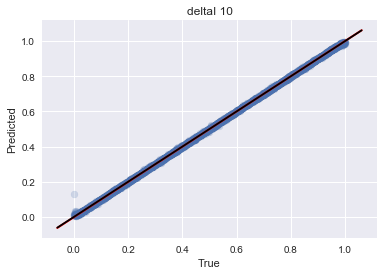

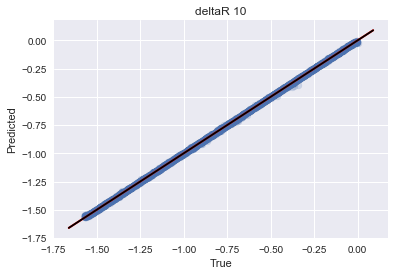

In [11]:
rs = 42
E0Ma_regr_RF_both = RandomForestRegressor(max_depth = 40, n_estimators = 30, random_state=rs)

E0Ma_model_RF_both = E0Ma_regr_RF_both.fit(X_train, Y_train)

E0Ma_predictions_RF_both = E0Ma_model_RF_both.predict(X_test)

E0Ma_scores_RF_both = [r2_score(Y_test['deltaI'], E0Ma_predictions_RF_both[:,0]), 
                   r2_score(Y_test['deltaR'], E0Ma_predictions_RF_both[:,1])]

plotSummary(Y_test['deltaI'], E0Ma_predictions_RF_both[:,0], 'deltaI 10')
plotSummary(Y_test['deltaR'], E0Ma_predictions_RF_both[:,1], 'deltaR 10')

## Independent Random Forests

### spec points

 
RMSE on test data: 0.00269185629844563 for  deltaI 10
R^2 Score on test data: 0.9999641280001437 for deltaI 10
 
RMSE on test data: 0.0021927005045762078 for  deltaR 10
R^2 Score on test data: 0.9999427371677655 for deltaR 10


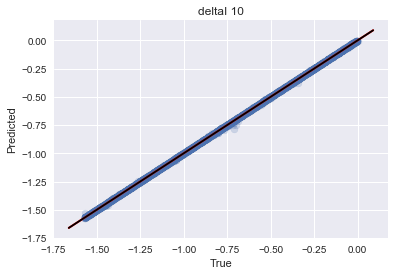

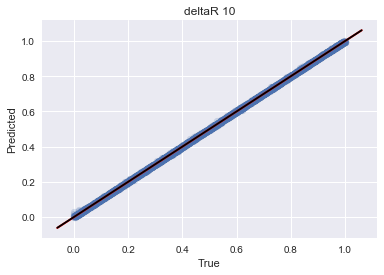

In [12]:
#Trying Independent Random Forest

rs = 42
md = 40
n = 40

E0Ma_regr_RF2_dr_sp = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)
E0Ma_regr_RF2_di_sp = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)


E0Ma_model_RF2_dr_sp = E0Ma_regr_RF2_dr_sp.fit(X1_train, Y1_train['deltaR'])
E0Ma_model_RF2_di_sp = E0Ma_regr_RF2_di_sp.fit(X1_train, Y1_train['deltaI'])

E0Ma_predictions_RF2_dr_sp = E0Ma_model_RF2_dr_sp.predict(X1_test)
E0Ma_predictions_RF2_di_sp = E0Ma_model_RF2_di_sp.predict(X1_test)

E0Ma_scores_RF2 = [r2_score(Y1_test['deltaI'], E0Ma_predictions_RF2_di_sp), 
              r2_score(Y1_test['deltaR'], E0Ma_predictions_RF2_dr_sp)]

plotSummary(Y1_test['deltaR'], E0Ma_predictions_RF2_dr_sp, 'deltaI 10')
plotSummary(Y1_test['deltaI'], E0Ma_predictions_RF2_di_sp, 'deltaR 10')


### peak info

 
RMSE on test data: 0.012390082013459364 for  deltaI 10
R^2 Score on test data: 0.9992400234223012 for deltaI 10
 
RMSE on test data: 0.01005159256517327 for  deltaR 10
R^2 Score on test data: 0.998796672216175 for deltaR 10


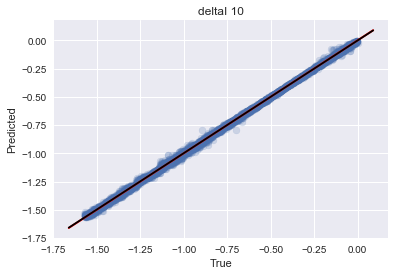

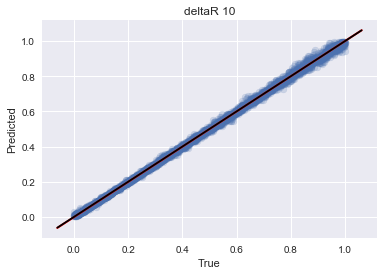

In [13]:
#Trying Independent Random Forest

rs = 42
md = 30
n = 30

E0Ma_regr_RF2_dr_pi = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)
E0Ma_regr_RF2_di_pi = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)

E0Ma_model_RF2_dr_pi = E0Ma_regr_RF2_dr_pi.fit(X2_train, Y2_train['deltaR'])
E0Ma_model_RF2_di_pi = E0Ma_regr_RF2_di_pi.fit(X2_train, Y2_train['deltaI'])

E0Ma_predictions_RF2_dr_pi = E0Ma_model_RF2_dr_pi.predict(X2_test)
E0Ma_predictions_RF2_di_pi = E0Ma_model_RF2_di_pi.predict(X2_test)

E0Ma_scores_RF2_pi = [r2_score(Y2_test['deltaI'], E0Ma_predictions_RF2_di_pi), 
                 r2_score(Y2_test['deltaR'], E0Ma_predictions_RF2_dr_pi)]

plotSummary(Y2_test['deltaR'], E0Ma_predictions_RF2_dr_pi, 'deltaI 10')
plotSummary(Y2_test['deltaI'], E0Ma_predictions_RF2_di_pi, 'deltaR 10')


### spec points and peak info

 
RMSE on test data: 0.0028462878155385294 for  deltaI 10
R^2 Score on test data: 0.9999598939886163 for deltaI 10
 
RMSE on test data: 0.0019147098296027074 for  deltaR 10
R^2 Score on test data: 0.9999563363411504 for deltaR 10


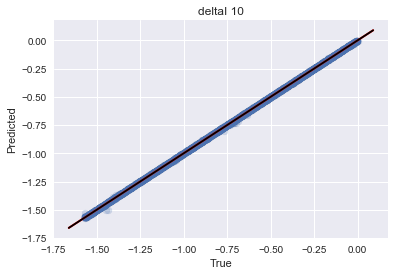

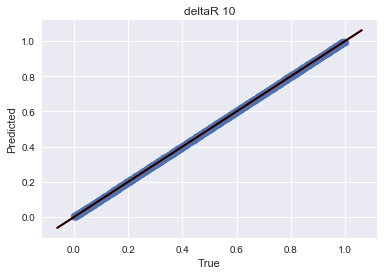

In [14]:
#Trying Independent Random Forest

rs = 42
md = 30
n = 30

E0Ma_regr_RF2_dr_both = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)
E0Ma_regr_RF2_di_both = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)

E0Ma_model_RF2_dr_both = E0Ma_regr_RF2_dr_both.fit(X_train, Y_train['deltaR'])
E0Ma_model_RF2_di_both = E0Ma_regr_RF2_di_both.fit(X_train, Y_train['deltaI'])

E0Ma_predictions_RF2_dr_both = E0Ma_model_RF2_dr_both.predict(X_test)
E0Ma_predictions_RF2_di_both = E0Ma_model_RF2_di_both.predict(X_test)

E0Ma_scores_RF2_both = [r2_score(Y_test['deltaI'], E0Ma_predictions_RF2_di_both), 
                 r2_score(Y_test['deltaR'], E0Ma_predictions_RF2_dr_both)]

plotSummary(Y_test['deltaR'], E0Ma_predictions_RF2_dr_both, 'deltaI 10')
plotSummary(Y_test['deltaI'], E0Ma_predictions_RF2_di_both, 'deltaR 10')


## AdaBoost Random Forests

### spec points

 
RMSE on test data: 0.003532161994007129 for  AdaBoost Delta I
R^2 Score on test data: 0.9998514080035282 for AdaBoost Delta I
 
RMSE on test data: 0.0027342449169565613 for  AdaBoost Delta R
R^2 Score on test data: 0.9999629893534256 for AdaBoost Delta R


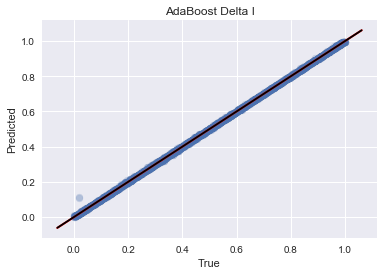

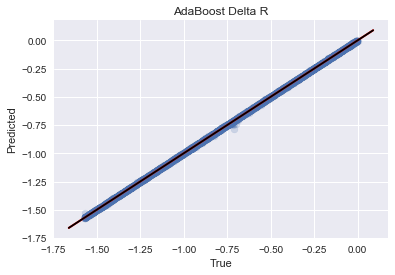

In [15]:
#Using AdaBoost Regression

from sklearn.ensemble import AdaBoostRegressor

rng = 42
md = 30
nest2 = 15

E0Ma_regr_AB_di_sp = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md), n_estimators=nest2, random_state=rng)
E0Ma_regr_AB_dr_sp = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md),n_estimators=nest2, random_state=rng)

E0Ma_model_AB_di_sp = E0Ma_regr_AB_di_sp.fit(X1_train, Y1_train['deltaI'])
E0Ma_model_AB_dr_sp = E0Ma_regr_AB_dr_sp.fit(X1_train, Y1_train['deltaR'])

E0Ma_predictions_AB_di_sp = E0Ma_model_AB_di_sp.predict(X1_test)
E0Ma_predictions_AB_dr_sp = E0Ma_model_AB_dr_sp.predict(X1_test)

E0Ma_scores_AB = [r2_score(Y1_test['deltaI'], E0Ma_predictions_AB_di_sp), 
             r2_score(Y1_test['deltaR'], E0Ma_predictions_AB_dr_sp)]

plotSummary(Y1_test['deltaI'], E0Ma_predictions_AB_di_sp, 'AdaBoost Delta I')
plotSummary(Y1_test['deltaR'], E0Ma_predictions_AB_dr_sp, 'AdaBoost Delta R')


### peak info

 
RMSE on test data: 0.010757044871328397 for  AdaBoost Delta I
R^2 Score on test data: 0.99862183837785 for AdaBoost Delta I
 
RMSE on test data: 0.012841891568015797 for  AdaBoost Delta R
R^2 Score on test data: 0.9991835871295598 for AdaBoost Delta R


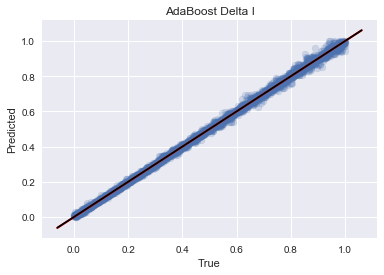

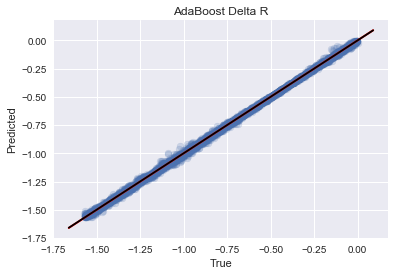

In [16]:
#Using AdaBoost Regression

from sklearn.ensemble import AdaBoostRegressor

rng = 42
md = 30
nest2 = 15

E0Ma_regr_AB_di_pi = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md), n_estimators=nest2, random_state=rng)
E0Ma_regr_AB_dr_pi = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md),n_estimators=nest2, random_state=rng)

E0Ma_model_AB_di_pi = E0Ma_regr_AB_di_pi.fit(X2_train, Y2_train['deltaI'])
E0Ma_model_AB_dr_pi = E0Ma_regr_AB_dr_pi.fit(X2_train, Y2_train['deltaR'])

E0Ma_predictions_AB_di_pi = E0Ma_model_AB_di_pi.predict(X2_test)
E0Ma_predictions_AB_dr_pi = E0Ma_model_AB_dr_pi.predict(X2_test)

E0Ma_scores_AB_pi = [r2_score(Y2_test['deltaI'], E0Ma_predictions_AB_di_pi), 
                r2_score(Y2_test['deltaR'], E0Ma_predictions_AB_dr_pi)]

plotSummary(Y2_test['deltaI'], E0Ma_predictions_AB_di_pi, 'AdaBoost Delta I')
plotSummary(Y2_test['deltaR'], E0Ma_predictions_AB_dr_pi, 'AdaBoost Delta R')


### spec points and peak info

 
RMSE on test data: 0.0025723429764783656 for  AdaBoost Delta I
R^2 Score on test data: 0.9999211917037438 for AdaBoost Delta I
 
RMSE on test data: 0.002984521100529741 for  AdaBoost Delta R
R^2 Score on test data: 0.9999559038013036 for AdaBoost Delta R


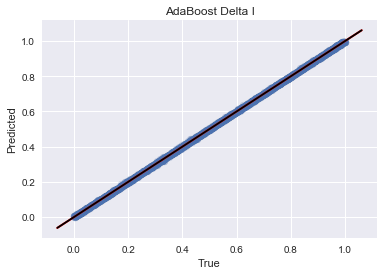

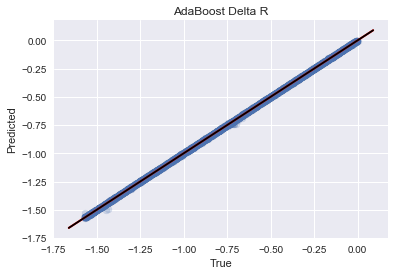

In [17]:
#Using AdaBoost Regression

from sklearn.ensemble import AdaBoostRegressor

rng = 42
md = 30
nest2 = 15

E0Ma_regr_AB_di_both = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md), n_estimators=nest2, random_state=rng)
E0Ma_regr_AB_dr_both = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md),n_estimators=nest2, random_state=rng)

E0Ma_model_AB_di_both = E0Ma_regr_AB_di_both.fit(X_train, Y_train['deltaI'])
E0Ma_model_AB_dr_both = E0Ma_regr_AB_dr_both.fit(X_train, Y_train['deltaR'])

E0Ma_predictions_AB_di_both = E0Ma_model_AB_di_both.predict(X_test)
E0Ma_predictions_AB_dr_both = E0Ma_model_AB_dr_both.predict(X_test)

E0Ma_scores_AB_both = [r2_score(Y_test['deltaI'], E0Ma_predictions_AB_di_both), 
                r2_score(Y_test['deltaR'], E0Ma_predictions_AB_dr_both)]

plotSummary(Y_test['deltaI'], E0Ma_predictions_AB_di_both, 'AdaBoost Delta I')
plotSummary(Y_test['deltaR'], E0Ma_predictions_AB_dr_both, 'AdaBoost Delta R')



## Gradient Boosting Random Forests

### spec points

 
RMSE on test data: 0.013200996639907356 for  GradientBoost Delta I
R^2 Score on test data: 0.997924476607714 for GradientBoost Delta I
 
RMSE on test data: 0.019295170950092026 for  GradientBoost Delta R
R^2 Score on test data: 0.9981568991188777 for GradientBoost Delta R


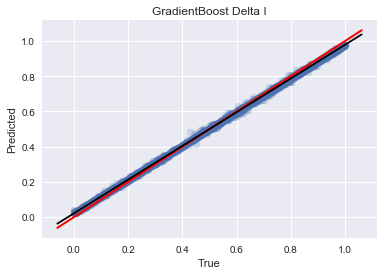

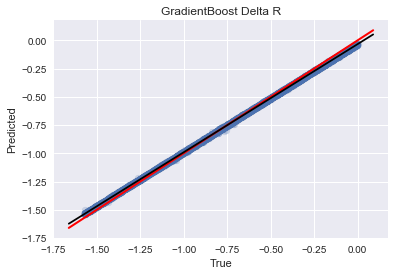

In [18]:
# Using Gradient Boosting Regression

from sklearn.ensemble import GradientBoostingRegressor

rng = 42

md = 50
nest2 = 30


E0Ma_regr_GB_di_sp = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)
E0Ma_regr_GB_dr_sp = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)

E0Ma_model_GB_di_sp = E0Ma_regr_GB_di_sp.fit(X1_train, Y1_train['deltaI'])
E0Ma_model_GB_dr_sp = E0Ma_regr_GB_dr_sp.fit(X1_train, Y1_train['deltaR'])


E0Ma_predictions_GB_di_sp = E0Ma_model_GB_di_sp.predict(X1_test)
E0Ma_predictions_GB_dr_sp = E0Ma_model_GB_dr_sp.predict(X1_test)

E0Ma_scores_GB = [r2_score(Y1_test['deltaI'], E0Ma_predictions_GB_di_sp), 
                r2_score(Y1_test['deltaR'], E0Ma_predictions_GB_dr_sp)]

plotSummary(Y1_test['deltaI'], E0Ma_predictions_GB_di_sp, 'GradientBoost Delta I')
plotSummary(Y1_test['deltaR'], E0Ma_predictions_GB_dr_sp, 'GradientBoost Delta R')


### peak info

 
RMSE on test data: 0.016700606992777124 for  GradientBoost Delta I
R^2 Score on test data: 0.9966781600511984 for GradientBoost Delta I
 
RMSE on test data: 0.02398425232177568 for  GradientBoost Delta R
R^2 Score on test data: 0.9971522345658145 for GradientBoost Delta R


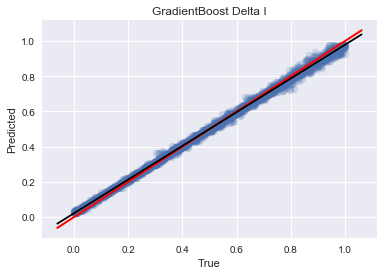

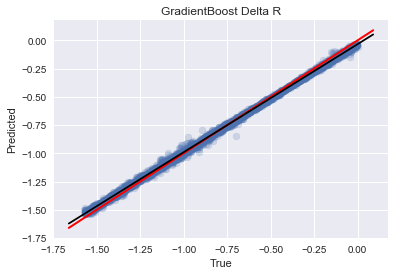

In [19]:
# Using Gradient Boosting Regression

from sklearn.ensemble import GradientBoostingRegressor

rng = 42

md = 50
nest2 = 30


E0Ma_regr_GB_di_pi = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)
E0Ma_regr_GB_dr_pi = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)

E0Ma_model_GB_di_pi = E0Ma_regr_GB_di_pi.fit(X2_train, Y2_train['deltaI'])
E0Ma_model_GB_dr_pi = E0Ma_regr_GB_dr_pi.fit(X2_train, Y2_train['deltaR'])

E0Ma_predictions_GB_di_pi = E0Ma_model_GB_di_pi.predict(X2_test)
E0Ma_predictions_GB_dr_pi = E0Ma_model_GB_dr_pi.predict(X2_test)

E0Ma_scores_GB_pi = [r2_score(Y2_test['deltaI'], E0Ma_predictions_GB_di_pi), 
                r2_score(Y2_test['deltaR'], E0Ma_predictions_GB_dr_pi)]

plotSummary(Y2_test['deltaI'], E0Ma_predictions_GB_di_pi, 'GradientBoost Delta I')
plotSummary(Y2_test['deltaR'], E0Ma_predictions_GB_dr_pi, 'GradientBoost Delta R')




### spec points and peak info

 
RMSE on test data: 0.01292790089139902 for  GradientBoost Delta I
R^2 Score on test data: 0.9980094631610035 for GradientBoost Delta I
 
RMSE on test data: 0.01962950827083371 for  GradientBoost Delta R
R^2 Score on test data: 0.9980924730332443 for GradientBoost Delta R


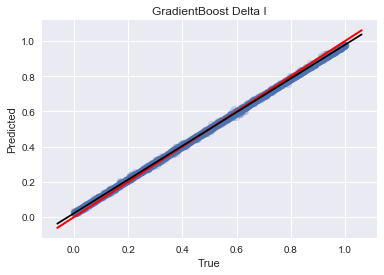

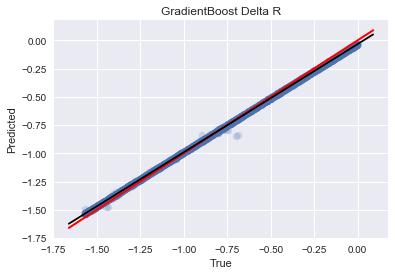

In [20]:
# Using Gradient Boosting Regression

from sklearn.ensemble import GradientBoostingRegressor

rng = 42

md = 50
nest2 = 30


E0Ma_regr_GB_di_both = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)
E0Ma_regr_GB_dr_both = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)

E0Ma_model_GB_di_both = E0Ma_regr_GB_di_both.fit(X_train, Y_train['deltaI'])
E0Ma_model_GB_dr_both = E0Ma_regr_GB_dr_both.fit(X_train, Y_train['deltaR'])

E0Ma_predictions_GB_di_both = E0Ma_model_GB_di_both.predict(X_test)
E0Ma_predictions_GB_dr_both = E0Ma_model_GB_dr_both.predict(X_test)

E0Ma_scores_GB_both = [r2_score(Y_test['deltaI'], E0Ma_predictions_GB_di_both), 
                r2_score(Y_test['deltaR'], E0Ma_predictions_GB_dr_both)]

plotSummary(Y_test['deltaI'], E0Ma_predictions_GB_di_both, 'GradientBoost Delta I')
plotSummary(Y_test['deltaR'], E0Ma_predictions_GB_dr_both, 'GradientBoost Delta R')



## Testing on the Experimental Data

In [21]:
# Load the experimental data
col_names3 = peak_names + locs_names + width_names + prom_names
col_names4 = energy_names

exp_data_sp = pd.read_csv('Training_Data/Hexagon/HexagonExperimentalData062218_v8_specPoints.csv', header = None, names = col_names4)
exp_data_pi = pd.read_csv('Training_Data/Hexagon/HexagonExperimentalData062218_v8_peakinfo.csv', header = None, names = col_names3)

col_names_exp_both = col_names_both[5:]
col_names_exp_pi = col_names2a[5:]
col_names_exp_a = col_names_a[5:]

exp_data_both = exp_data_sp.join(exp_data_pi, how = 'left')
exp_data_both = exp_data_both[col_names_exp_both]

exp_data_sp = exp_data_sp[col_names_exp_a]
exp_data_pi = exp_data_pi[col_names_exp_pi]

E0Ma_pred_phase_OLS_R_sp = E0Ma_results_OLS_R_sp.predict(exp_data_sp)
E0Ma_pred_phase_OLS_I_sp = E0Ma_results_OLS_I_sp.predict(exp_data_sp)

E0Ma_pred_phase_OLS_R_pi = E0Ma_results_OLS_R_pi.predict(exp_data_pi)
E0Ma_pred_phase_OLS_I_pi = E0Ma_results_OLS_I_pi.predict(exp_data_pi)

E0Ma_pred_phase_OLS_R_both = E0Ma_results_OLS_R_both.predict(exp_data_both)
E0Ma_pred_phase_OLS_I_both = E0Ma_results_OLS_I_both.predict(exp_data_both)

E0Ma_phases_OLS_sp = [E0Ma_pred_phase_OLS_I_sp[0], 
                    E0Ma_pred_phase_OLS_R_pi[0]]

E0Ma_phases_OLS_pi = [E0Ma_pred_phase_OLS_I_pi[0], 
                    E0Ma_pred_phase_OLS_R_pi[0]]

E0Ma_phases_OLS_both = [E0Ma_pred_phase_OLS_I_both[0], 
                    E0Ma_pred_phase_OLS_R_both[0]]

#pred_phase_DT_sp = np.append(regr_DT_sp.predict(exp_data_sp),r2_score(Y1_test['deltaI'], predictions_DT_sp[:,0])).reshape(3,1).T
#pred_phase_DT_sp = np.append(pred_phase_DT_sp, r2_score(Y1_test['deltaR'], predictions_DT_sp[:,1])).reshape(4,1).T
#pred_phase_DT = np.append(pred_phase_DT, r2_score(Y_test['scale_factor'], y_pred_DT[:,2]))
E0Ma_phases_DT_sp = E0Ma_regr_DT_sp.predict(exp_data_sp)
E0Ma_phases_DT_pi = E0Ma_regr_DT_pi.predict(exp_data_pi)
E0Ma_phases_DT_both = E0Ma_regr_DT_both.predict(exp_data_both)

E0Ma_phases_RF_sp = E0Ma_regr_RF_sp.predict(exp_data_sp)
E0Ma_phases_RF_pi = E0Ma_regr_RF_pi.predict(exp_data_pi)
E0Ma_phases_RF_both = E0Ma_regr_RF_both.predict(exp_data_both)

E0Ma_pred_phase_AB_R_sp = E0Ma_model_AB_dr_sp.predict(exp_data_sp)
E0Ma_pred_phase_AB_I_sp = E0Ma_model_AB_di_sp.predict(exp_data_sp)

E0Ma_pred_phase_AB_R_pi = E0Ma_model_AB_dr_pi.predict(exp_data_pi)
E0Ma_pred_phase_AB_I_pi = E0Ma_model_AB_di_pi.predict(exp_data_pi)

E0Ma_pred_phase_AB_R_both = E0Ma_model_AB_dr_both.predict(exp_data_both)
E0Ma_pred_phase_AB_I_both = E0Ma_model_AB_di_both.predict(exp_data_both)

E0Ma_phases_AB_sp = [E0Ma_pred_phase_AB_I_sp[0], 
                   E0Ma_pred_phase_AB_R_sp[0]]

E0Ma_phases_AB_pi = [E0Ma_pred_phase_AB_I_pi[0], 
                   E0Ma_pred_phase_AB_R_pi[0]]

E0Ma_phases_AB_both = [E0Ma_pred_phase_AB_I_both[0], 
                   E0Ma_pred_phase_AB_R_both[0]]

E0Ma_pred_phase_GB_di_sp = E0Ma_model_GB_di_sp.predict(exp_data_sp)
E0Ma_pred_phase_GB_dr_sp = E0Ma_model_GB_dr_sp.predict(exp_data_sp)

E0Ma_pred_phase_GB_di_pi = E0Ma_model_GB_di_pi.predict(exp_data_pi)
E0Ma_pred_phase_GB_dr_pi = E0Ma_model_GB_dr_pi.predict(exp_data_pi)

E0Ma_pred_phase_GB_di_both = E0Ma_model_GB_di_both.predict(exp_data_both)
E0Ma_pred_phase_GB_dr_both = E0Ma_model_GB_dr_both.predict(exp_data_both)

E0Ma_phases_GB_sp = [E0Ma_pred_phase_GB_di_sp[0], 
                   E0Ma_pred_phase_GB_dr_sp[0]]

E0Ma_phases_GB_pi = [E0Ma_pred_phase_GB_di_pi[0], 
                   E0Ma_pred_phase_GB_dr_pi[0]]

E0Ma_phases_GB_both = [E0Ma_pred_phase_GB_di_both[0], 
                   E0Ma_pred_phase_GB_dr_both[0]]

E0Ma_pred_phase_IRF_di_sp = E0Ma_model_RF2_di_sp.predict(exp_data_sp)
E0Ma_pred_phase_IRF_dr_sp = E0Ma_model_RF2_dr_sp.predict(exp_data_sp)

E0Ma_pred_phase_IRF_di_pi = E0Ma_model_RF2_di_pi.predict(exp_data_pi)
E0Ma_pred_phase_IRF_dr_pi = E0Ma_model_RF2_dr_pi.predict(exp_data_pi)

E0Ma_pred_phase_IRF_di_both = E0Ma_model_RF2_di_both.predict(exp_data_both)
E0Ma_pred_phase_IRF_dr_both = E0Ma_model_RF2_dr_both.predict(exp_data_both)

E0Ma_phases_IRF_sp = [E0Ma_pred_phase_IRF_di_sp[0], 
                    E0Ma_pred_phase_IRF_dr_sp[0]]

E0Ma_phases_IRF_pi = [E0Ma_pred_phase_IRF_di_pi[0], 
                    E0Ma_pred_phase_IRF_dr_pi[0]]

E0Ma_phases_IRF_both = [E0Ma_pred_phase_IRF_di_both[0], 
                    E0Ma_pred_phase_IRF_dr_both[0]]

E0Ma_predictedPhases = pd.DataFrame([], columns = ['deltaI', 'deltaR'])

E0Ma_predictedPhases.loc['OLS_sp'] = E0Ma_phases_OLS_sp
E0Ma_predictedPhases.loc['OLS_pi'] = E0Ma_phases_OLS_pi
E0Ma_predictedPhases.loc['OLS_both'] = E0Ma_phases_OLS_both
E0Ma_predictedPhases.loc['DT_sp'] = E0Ma_phases_DT_sp.tolist()[0]
E0Ma_predictedPhases.loc['DT_pi'] = E0Ma_phases_DT_pi.tolist()[0]
E0Ma_predictedPhases.loc['DT_both'] = E0Ma_phases_DT_both.tolist()[0]
E0Ma_predictedPhases.loc['RF_sp'] = E0Ma_phases_RF_sp.tolist()[0]
E0Ma_predictedPhases.loc['RF_pi'] = E0Ma_phases_RF_pi.tolist()[0]
E0Ma_predictedPhases.loc['RF_both'] = E0Ma_phases_RF_both.tolist()[0]
E0Ma_predictedPhases.loc['IRF_sp'] = E0Ma_phases_IRF_sp
E0Ma_predictedPhases.loc['IRF_pi'] = E0Ma_phases_IRF_pi
E0Ma_predictedPhases.loc['IRF_both'] = E0Ma_phases_IRF_both
E0Ma_predictedPhases.loc['AB_sp'] = E0Ma_phases_AB_sp
E0Ma_predictedPhases.loc['AB_pi'] = E0Ma_phases_AB_pi
E0Ma_predictedPhases.loc['AB_both'] = E0Ma_phases_AB_both
E0Ma_predictedPhases.loc['GB_sp'] = E0Ma_phases_GB_sp
E0Ma_predictedPhases.loc['GB_pi'] = E0Ma_phases_GB_pi
E0Ma_predictedPhases.loc['GB_both'] = E0Ma_phases_GB_both

E0Ma_Scores = pd.DataFrame([], columns = ['deltaI', 'deltaR'])

E0Ma_Scores.loc['OLS_sp'] = E0Ma_scores_OLS
E0Ma_Scores.loc['OLS_pi'] = E0Ma_scores_OLS_pi
E0Ma_Scores.loc['OLS_both'] = E0Ma_scores_OLS_both
E0Ma_Scores.loc['DT_sp'] = E0Ma_scores_DT
E0Ma_Scores.loc['DT_pi'] = E0Ma_scores_DT_pi
E0Ma_Scores.loc['DT_both'] = E0Ma_scores_DT_both
E0Ma_Scores.loc['RF_sp'] = E0Ma_scores_RF
E0Ma_Scores.loc['RF_pi'] = E0Ma_scores_RF_pi
E0Ma_Scores.loc['RF_both'] = E0Ma_scores_RF_both
E0Ma_Scores.loc['IRF_sp'] = E0Ma_scores_RF2
E0Ma_Scores.loc['IRF_pi'] = E0Ma_scores_RF2_pi
E0Ma_Scores.loc['IRF_both'] = E0Ma_scores_RF2_both
E0Ma_Scores.loc['AB_sp'] = E0Ma_scores_AB
E0Ma_Scores.loc['AB_pi'] = E0Ma_scores_AB_pi
E0Ma_Scores.loc['AB_both'] = E0Ma_scores_AB_both
E0Ma_Scores.loc['GB_sp'] = E0Ma_scores_GB
E0Ma_Scores.loc['GB_pi'] = E0Ma_scores_GB_pi
E0Ma_Scores.loc['GB_both'] = E0Ma_scores_GB_both

E0Ma_Scores

,deltaI,deltaR
OLS_sp,-5666.825131,-789.690890
OLS_pi,0.788349,0.534854
OLS_both,0.837168,-0.251494
DT_sp,0.998860,0.999440
DT_pi,0.997897,0.998574
DT_both,0.998762,0.999443
RF_sp,0.999827,0.999941
RF_pi,0.998798,0.999190
RF_both,0.999808,0.999916
IRF_sp,0.999943,0.999964


In [28]:
score_threshold = 0.95

avg_di = E0Ma_predictedPhases[E0Ma_Scores > score_threshold]['deltaI'].mean()
avg_dr = E0Ma_predictedPhases[E0Ma_Scores > score_threshold]['deltaR'].mean()

avg_di, avg_dr

(0.0237278651962279, -0.09736479041223042)

In [26]:
E0Ma_predictedPhases[E0Ma_Scores>score_threshold]

,deltaI,deltaR
OLS_sp,NaN,NaN
OLS_pi,NaN,NaN
OLS_both,NaN,NaN
DT_sp,0.022932,-0.064476
DT_pi,0.068284,-0.181450
DT_both,0.022932,-0.064476
RF_sp,0.031831,-0.068910
RF_pi,0.045799,-0.164512
RF_both,0.036389,-0.075908
IRF_sp,0.008382,-0.035176


In [24]:
if save_data == True:
    E0Ma_predictedPhases.to_csv('Model_Results/Hexagon/predictions_v7_threekinds_E0Mafixed_limitallrange300_removepeak1prom1.csv')
    E0Ma_Scores.to_csv('Model_Results/Hexagon/scores_v7_threekinds_E0Mafixed_limitallrange300_removepeak1prom1.csv')